# Demonstrations and Timings of HARK.expected


First, we import the relevant libraries.


In [1]:
from time import time

import numpy as np
from HARK.distribution import (
    MeanOneLogNormal,
    Normal,
    calc_expectation,
    combine_indep_dstns,
)

Next, we define discrete distributions as approximations of continuous distributions.


In [2]:
dd_0_1_20 = Normal().discretize(20)
dd_1_1_40 = Normal(mu=1).discretize(40)
dd_10_10_100 = Normal(mu=10, sigma=10).discretize(100)

### The **new** `DiscreteDistribution.expected()` method


There are two ways to get the expectation of a distribution. The first is to use the **new** `expected()` method of the distribution shown below.


In [3]:
%%timeit
ce1 = dd_0_1_20.expected()
ce2 = dd_1_1_40.expected()
ce3 = dd_10_10_100.expected()

4.33 µs ± 18.3 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


The second is to use `HARK.distribution.calc_expectation()`. Comparing the timings, the first method is significantly faster.


In [4]:
%%timeit
ce1 = calc_expectation(dd_0_1_20)
ce2 = calc_expectation(dd_1_1_40)
ce3 = calc_expectation(dd_10_10_100)

202 µs ± 1.8 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


### The Expected Value of a function of a random variable


Both of these methods allow us to calculate the expected value of a function of the distribution. Using the first method, which is the distribution's own method, we only need to provide the function.


In [5]:
%%timeit
ce4 = dd_0_1_20.expected(lambda x: 2**x)
ce5 = dd_1_1_40.expected(lambda x: 2 * x)

9.86 µs ± 82.3 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


Using `HARK.distribution.calc_expectation()`, we first provide the distribution and then the function.


In [6]:
%%timeit
ce4 = calc_expectation(dd_0_1_20, lambda x: 2**x)
ce5 = calc_expectation(dd_1_1_40, lambda x: 2 * x)

208 µs ± 10.2 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


#### The expected value of a function with additional arguments


For both methods, we can also provide a number of arguments to the function `args`, which are passed to the function and gets called as `func(dstn,*args)`.


In [7]:
%%timeit
ce6 = dd_10_10_100.expected(lambda x, y: 2 * x + y, 20)
ce7 = dd_0_1_20.expected(lambda x, y: x + y, np.hstack([0, 1, 2, 3, 4, 5]))

28 µs ± 858 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [8]:
%%timeit
ce6 = calc_expectation(dd_10_10_100, lambda x, y: 2 * x + y, 20)
ce7 = calc_expectation(dd_0_1_20, lambda x, y: x + y, np.hstack([0, 1, 2, 3, 4, 5]))

515 µs ± 4.25 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


### The expected value of a function in `HARK`


For a more practical demonstration of these methods as they would be used in `HARK`, we can create a distcrete distribution of shocks to income `IncShkDstn`. Given an array of liquid assets `aGrid` and an interest rate `R`, we can calculate the expected value of next period's cash on hand as the function `m_next = R * aGrid / perm_shk + tran_shk`. Below we see how this is done. Notice that the arguments to the function can be multidimensional.


In [9]:
PermShkDstn = MeanOneLogNormal().discretize(200)
TranShkDstn = MeanOneLogNormal().discretize(200)
IncShkDstn = combine_indep_dstns(PermShkDstn, TranShkDstn)
aGrid = np.linspace(0, 20, 100)  # aNrm grid
R = 1.05  # interest rate


def m_next(x, aGrid, R):
    return R * aGrid / x[0] + x[1]

In [10]:
%%timeit
ce8 = IncShkDstn.expected(m_next, aGrid, R)
ce9 = IncShkDstn.expected(m_next, aGrid.reshape((10, 10)), R)

81.3 ms ± 7.25 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [11]:
%%timeit
ce8 = calc_expectation(IncShkDstn, m_next, aGrid, R)
ce9 = calc_expectation(IncShkDstn, m_next, aGrid.reshape((10, 10)), R)

582 ms ± 29.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Time Comparison of the two methods


As a final comparision of these two methods, we can see how the time difference is affected by the number of points in the distribution.


In [12]:
size = np.arange(1, 11) * 100

t_self = []
t_dist = []

for n in size:
    PermShkDstn = MeanOneLogNormal().discretize(n)
    TranShkDstn = MeanOneLogNormal().discretize(n)
    IncShkDstn = combine_indep_dstns(PermShkDstn, TranShkDstn)

    m_next = lambda X, a, r: r * a / X[0] + X[1]
    a_grid = np.linspace(0, 20, 100).reshape((10, 10))
    R = 1.05

    start_self = time()
    ce_self = IncShkDstn.expected(m_next, a_grid, R)
    time_self = time() - start_self

    start_dist = time()
    ce_dist = calc_expectation(IncShkDstn, m_next, a_grid, R)
    time_dist = time() - start_dist

    t_self.append(time_self)
    t_dist.append(time_dist)

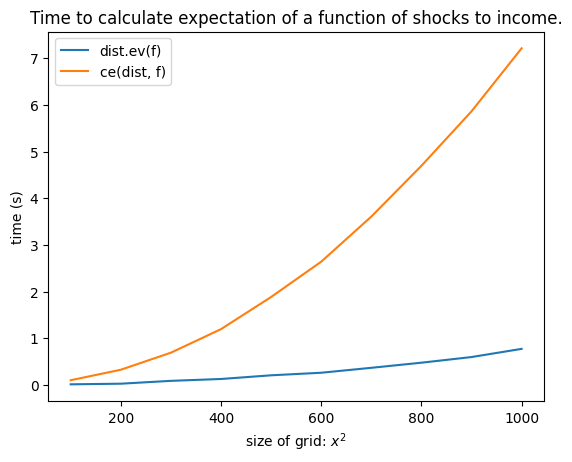

In [13]:
import matplotlib.pyplot as plt

plt.plot(size, t_self, label="dist.ev(f)")
plt.plot(size, t_dist, label="ce(dist, f)")
plt.title("Time to calculate expectation of a function of shocks to income.")
plt.ylabel("time (s)")
plt.xlabel("size of grid: $x^2$")
plt.legend()
plt.show()

### Aliases for the new `expected()` method


There is a top-level alias for the new `expected()` method to make it clearer as a mathematical expression. The way to access it is as follows:

`expected(func, dstn, *args)`


In [14]:
from HARK.distribution import expected

In [15]:
expected(func=m_next, dist=IncShkDstn, args=(aGrid, R))

array([ 1.        ,  1.57585002,  2.15170003,  2.72755005,  3.30340006,
        3.87925008,  4.4551001 ,  5.03095011,  5.60680013,  6.18265014,
        6.75850016,  7.33435017,  7.91020019,  8.48605021,  9.06190022,
        9.63775024, 10.21360025, 10.78945027, 11.36530029, 11.9411503 ,
       12.51700032, 13.09285033, 13.66870035, 14.24455036, 14.82040038,
       15.3962504 , 15.97210041, 16.54795043, 17.12380044, 17.69965046,
       18.27550048, 18.85135049, 19.42720051, 20.00305052, 20.57890054,
       21.15475056, 21.73060057, 22.30645059, 22.8823006 , 23.45815062,
       24.03400063, 24.60985065, 25.18570067, 25.76155068, 26.3374007 ,
       26.91325071, 27.48910073, 28.06495075, 28.64080076, 29.21665078,
       29.79250079, 30.36835081, 30.94420082, 31.52005084, 32.09590086,
       32.67175087, 33.24760089, 33.8234509 , 34.39930092, 34.97515094,
       35.55100095, 36.12685097, 36.70270098, 37.278551  , 37.85440102,
       38.43025103, 39.00610105, 39.58195106, 40.15780108, 40.73

In [16]:
expected(func=lambda x: 1 / x[0] + x[1], dist=IncShkDstn)

3.7147215033526995